## Bike Rental Prediction: Linear Regression

This project aims at predicting bike rental rate based on weather and holiday information. The dataset contains hourly count of public bikes rented in Seoul Bike Sharing System, along with the corresponding weather data and holidays information, and is available at: https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv

In this notebook, we use linear regression model to predict bike rental rate

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
# reading feature-engineered saved data file
df = pd.read_pickle('data_feat_eng.pkl')

In [3]:
# see the head of dataframe
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Month,Year,No Holiday,Funct_Day
0,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,12,0,1,1
1,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,12,0,1,1
2,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,12,0,1,1
3,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,12,0,1,1
4,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,12,0,1,1


In [4]:
# some information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8760 non-null   int64  
 1   Hour                       8760 non-null   int64  
 2   Temperature(°C)            8760 non-null   float64
 3   Humidity(%)                8760 non-null   int64  
 4   Wind speed (m/s)           8760 non-null   float64
 5   Visibility (10m)           8760 non-null   int64  
 6   Dew point temperature(°C)  8760 non-null   float64
 7   Solar Radiation (MJ/m2)    8760 non-null   int64  
 8   Rainfall(mm)               8760 non-null   int64  
 9   Snowfall (cm)              8760 non-null   int64  
 10  Month                      8760 non-null   int64  
 11  Year                       8760 non-null   int64  
 12  No Holiday                 8760 non-null   uint8  
 13  Funct_Day                  8760 non-null   uint8

There are 13 numerical features

### Train-Test Splitting of Data

In [5]:
# features and labels are singled out of the dataframe

X = df.drop(['Rented Bike Count'],axis=1)
y = df['Rented Bike Count']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Data pre-processing

Pairwise correlation of features, if high, may suggest throwing away some of the features

Text(0.5, 1.0, 'Pairwise Correlation of Featues')

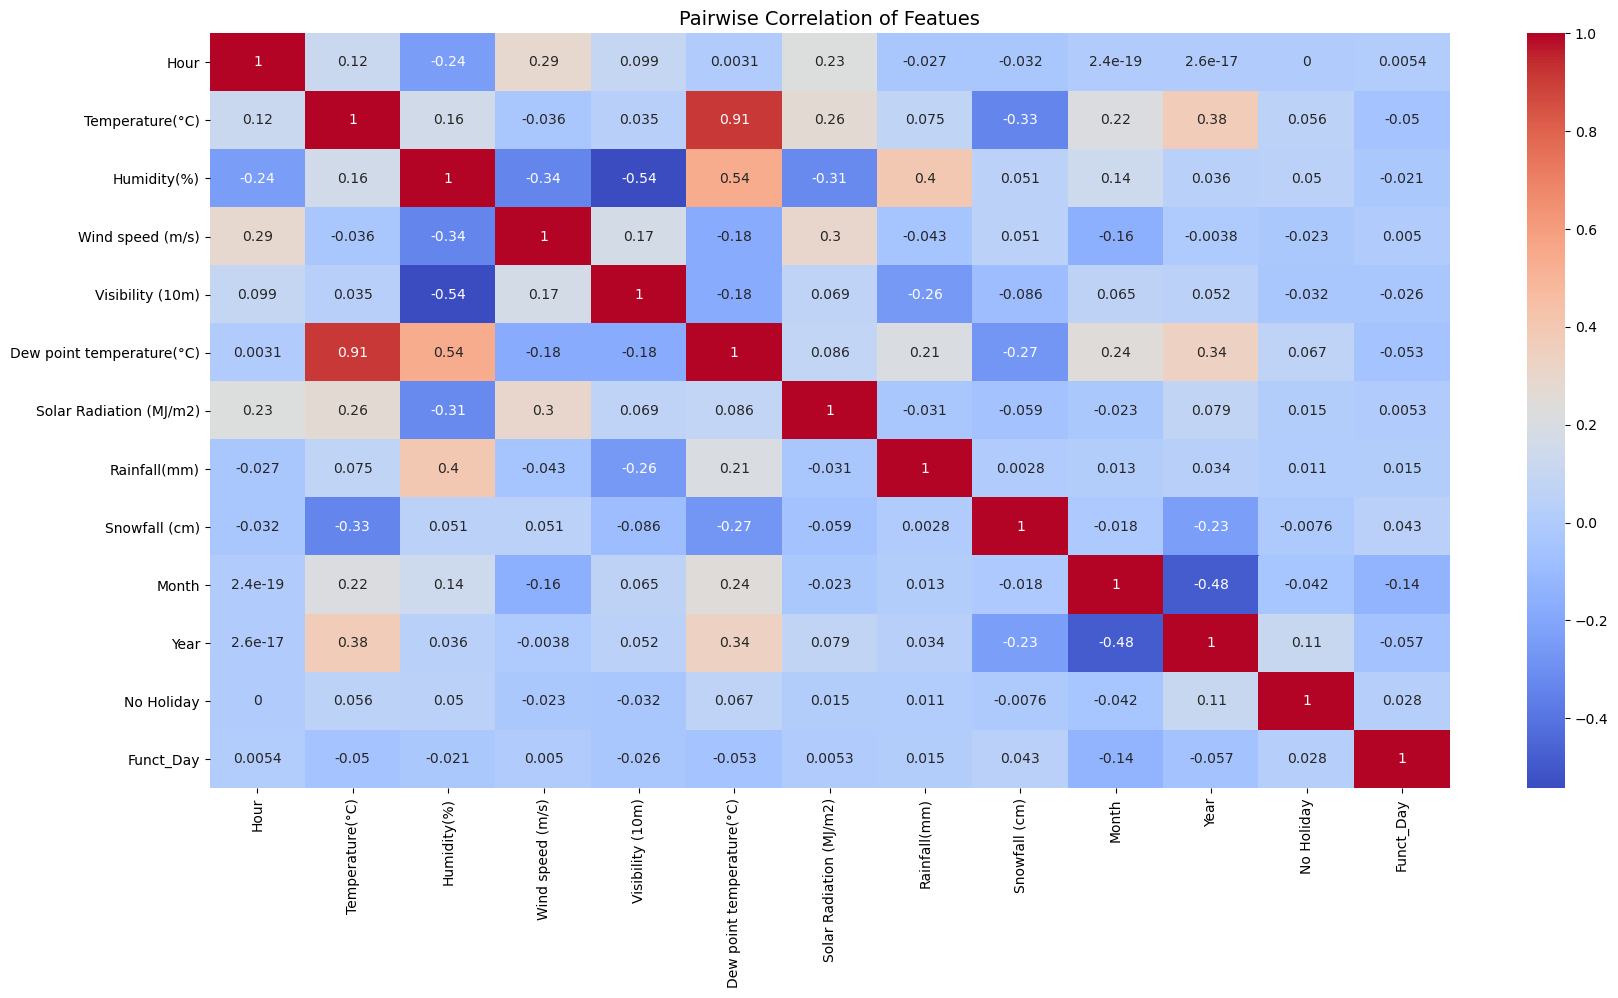

In [6]:
# pairwise correlation of featues
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(X.corr(),cmap='coolwarm',annot=True)
plt.title('Pairwise Correlation of Featues', fontsize=14)

There is a single highly correlated pair. We may need to perform PCA

#### Principal Component Analysis

In [7]:
from sklearn.preprocessing import MinMaxScaler

# feature scaling
sc = MinMaxScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

To see how many principal components may be needed, let us plot cumulative explained variance

Text(0, 0.5, 'Cumulative explained variance')

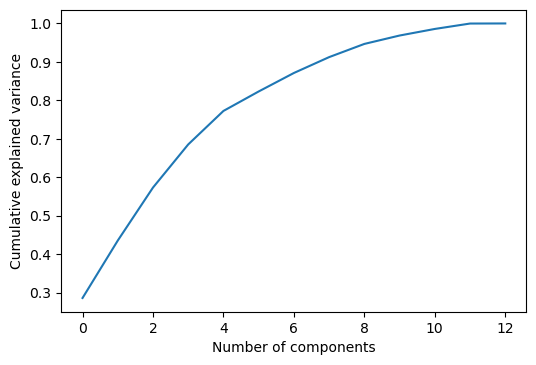

In [8]:
from sklearn.decomposition import PCA

# making the list of cumulative explained variance
pca = PCA().fit(X_train_std)
cumsum_list = pca.explained_variance_ratio_.cumsum()

# making the plot of cumulative explained variance
plt.figure(dpi=100)
plt.plot(cumsum_list)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

We will retain as many principal components as account for 99% cumulative variance:

In [9]:
pc_model = PCA(n_components=0.99, svd_solver='full')
pc_model.fit(X_train_std)
pc_model.n_components_ 

12

This rids of one more feature

### Creating the Model

In [10]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [11]:
# create pipeline
pipeline = Pipeline([('sc',sc),    # feature scaling
                     ('pca',pc_model),  # principal component selection
                     ('lr',LinearRegression())]) # linear regression

### Training the Model

In [12]:
# train the model
pipeline.fit(X_train,y_train)

Pipeline(steps=[('sc', MinMaxScaler()),
                ('pca', PCA(n_components=0.99, svd_solver='full')),
                ('lr', LinearRegression())])

### Evaluation on Test Data

In [13]:
# predicted bike rental rate
y_pred = pipeline.predict(X_test)

Text(0, 0.5, 'Predicted value')

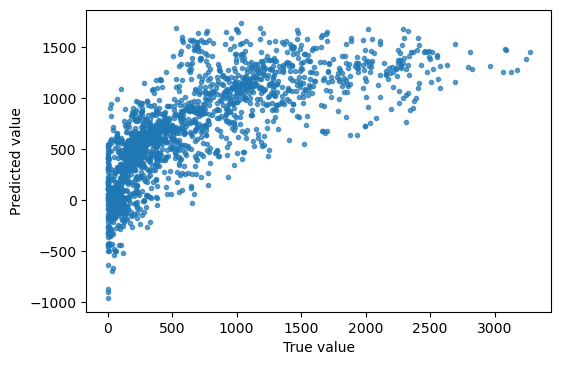

In [14]:
# plot of true rental rate against predicted value 
plt.figure(figsize=(6,4),dpi=100)
plt.plot(y_test.values,y_pred,'o',markersize=3,alpha=0.7)
plt.xlabel('True value')
plt.ylabel('Predicted value')

Plot is far from linear, so Linear Regression is not a good model

Text(0, 0.5, 'Probability Distribution')

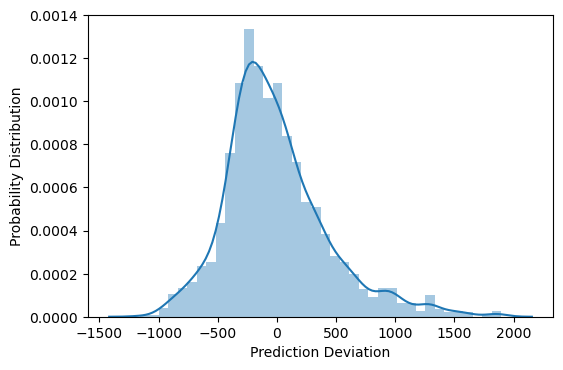

In [15]:
# distribution plot of prediction devations
plt.figure(figsize=(6,4),dpi=100)
sns.distplot(y_test.values-y_pred)
plt.xlabel('Prediction Deviation')
plt.ylabel('Probability Distribution')

Now we compute some performance metric in predicting the test values

In [16]:
from sklearn.metrics import explained_variance_score, r2_score

metric = {'value':[]}

# explained variance
exp_var = round(explained_variance_score(y_test,y_pred),3)
metric['value'].append(exp_var)

# R^2_score
r2 = round(r2_score(y_test,y_pred),3)
metric['value'].append(r2)

df_metric = pd.DataFrame(index=['explained_variance','R_squared'],
                         data=metric,
                         columns=['value'])

In [17]:
df_metric

,value
explained_variance,0.538
R_squared,0.538


Metric values are unsatisfactory. One needs some nonlinear regression model